In [1]:
using UMAP: umap
using MLDatasets
using VegaLite
using DataFrames
using OptimalTransport
# using Tulip
using Distances
using LinearAlgebra
using ImageTransformations
using Images

In [2]:
mnist_x = reshape(MNIST.traintensor(Float64),28*28,:)
mnist_y = MNIST.trainlabels(1:size(mnist_x, 2));

In [3]:
fmnist_x = reshape(FashionMNIST.traintensor(Float64),28*28,:)
fmnist_y = FashionMNIST.trainlabels(1:size(fmnist_x, 2));

In [4]:
mnist_img  = MNIST.convert2image(MNIST.traintensor());
fmnist_img = FashionMNIST.convert2image(FashionMNIST.traintensor());

In [5]:
N = 1000

1000

In [6]:
images = vcat([mnist_img[:,:,i] for i in 1:N],[fmnist_img[:,:,i] for i in 1:N]);

In [7]:
for i in 1:N
    save("./images/mnist_"*string(i)*".png",mnist_img[:,:,i])
end
for i in 1:N
    save("./images/fmnist_"*string(i)*".png",fmnist_img[:,:,i])
end

In [40]:
N = 100

res_jl = umap(hcat(mnist_x[:,1:N],fmnist_x[:,1:N]); n_neighbors=10, min_dist=0.001, n_epochs=200)

2×200 Matrix{Float64}:
 -0.558386  1.38772   0.869591   -1.90111    …  5.45183  5.54268   2.19423
  1.8065    4.02938  -0.0191558   0.0266739     1.79315  1.5622   -2.98303

In [41]:
img_url = vcat(
    ["./images/mnist_"*string(i)*".png" for i in 1:N],
    ["./images/fmnist_"*string(i)*".png" for i in 1:N]);

In [42]:
df = DataFrame(
    x1     = res_jl'[:,1],
    x2     = res_jl'[:,2],
    img    = img_url,
    label  = vcat(mnist_y[1:N],fmnist_y[1:N]),
    dataset= vcat(["mnist" for i in 1:N],["fmnist" for i in 1:N]));
df[!,"ld"] = string.(df[:,:label]) .* df[:,:dataset];

In [43]:
μ = res_jl[:,1:N]'
ν = res_jl[:,N+1:2*N]';
up = ones(N)/N
vp = ones(N)/N
C = pairwise(SqEuclidean(), μ', ν');
γ = sinkhorn(up,vp,C,1);

In [44]:
"""
    CreateEdges(μ,ν,γ)
Creates the edges for plotting.
μ and ν correspond to the positions of the mass
of the distributions.
"""
function CreateEdges(μ,ν,γ)
    edges = Array{Float64}(undef, 0, 2)
    pe    = []
    for i in 1:size(μ)[1], j in 1:size(ν)[1]
        edges  = vcat(edges,[μ[i,1],μ[i,2]]')
        edges  = vcat(edges,[ν[j,1],ν[j,2]]')
        pe     = vcat(pe,string([i,j]))
        pe     = vcat(pe,string([i,j]))
    end
    df = DataFrame(edges_x=edges[:,1],edges_y = edges[:,2],pe=pe);
    edge_w = []
    for i in 1:size(γ)[1], j in 1:size(γ)[1]
        edge_w = vcat(edge_w,γ[i,j])
        edge_w = vcat(edge_w,γ[i,j])
    end
    df[!,"ew"] = edge_w./maximum(edge_w);
    return df
end

"""
    PlotOT(μ,ν,γ;title="",width=200,height=200)
VegaLite.jl specification for creating visulizations
of Optimal Transport plan.
"""
function PlotOT(μ,ν,γ;filter=0.0,title="",width=300,height=300)
    df = CreateEdges(μ,ν,γ)
    df = df[df[:,:ew] .>= filter,:]
    v1 = @vlplot(
        mark={:circle,opacity=1},
        x={μ[:,1],type="quantitative",axis=nothing},
        y={μ[:,2],type="quantitative",axis=nothing},
        width=width,
        height=height)
    v2 = @vlplot(
        mark={"type"=:circle,color="red",opacity=1},
        x={ν[:,1],type="quantitative",axis=nothing},
        y={ν[:,2],type="quantitative",axis=nothing},
        width=width,
        height=height)

    v3 = @vlplot(
        mark={"type"=:line,color="black",clip=false},
        data = df,
        encoding={
        x={"edges_x:q",axis=nothing},
        y={"edges_y:q",axis=nothing},
        opacity={"ew:q",legend=nothing},
        size={"ew:o",scale={range=[0,2]},legend=nothing},
        detail={"pe:o"}},
        width=width,
        height=height
    )
    v = @vlplot(view={stroke=nothing},title={text=title, dy=-25, fontSize=14})+v3+v2+v1
    return v
end;

In [53]:
filter = 0.5
edges = CreateEdges(μ,ν,γ)
edges = edges[edges[:,:ew] .>= filter,:];
e1 = @vlplot(
        mark={"type"=:line,color="black",clip=false},
        data = edges,
        encoding={
        x={"edges_x:q",axis=nothing},
        y={"edges_y:q",axis=nothing},
        opacity={"ew:q",legend=nothing},
        size={"ew:o",scale={range=[0,2]},legend=nothing},
        detail={"pe:o"}}
    );

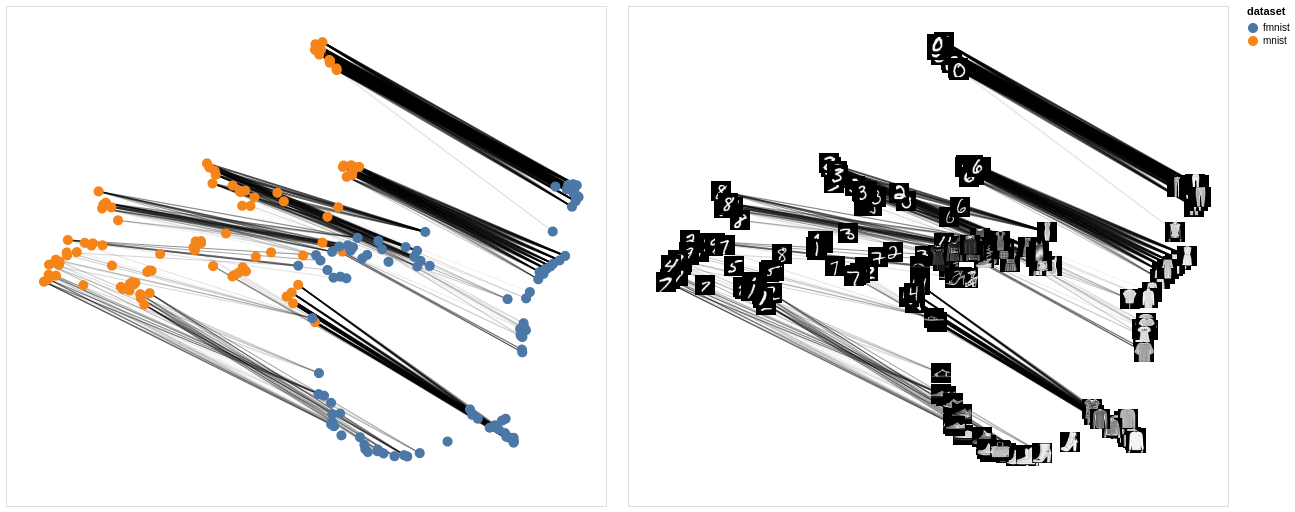

Error: Image given has not completed loading
    at /home/davibarreira/.julia/artifacts/f22a465460a987b8219c0c4c44b4a94e443a9a4c/node_modules/vega-scenegraph/build/vega-scenegraph.js:2260:17
    at visit (/home/davibarreira/.julia/artifacts/f22a465460a987b8219c0c4c44b4a94e443a9a4c/node_modules/vega-scenegraph/build/vega-scenegraph.js:1708:7)
    at CanvasRenderer.draw$3 (/home/davibarreira/.julia/artifacts/f22a465460a987b8219c0c4c44b4a94e443a9a4c/node_modules/vega-scenegraph/build/vega-scenegraph.js:2224:5)
    at CanvasRenderer.draw (/home/davibarreira/.julia/artifacts/f22a465460a987b8219c0c4c44b4a94e443a9a4c/node_modules/vega-scenegraph/build/vega-scenegraph.js:3687:17)
    at /home/davibarreira/.julia/artifacts/f22a465460a987b8219c0c4c44b4a94e443a9a4c/node_modules/vega-scenegraph/build/vega-scenegraph.js:2074:14
    at visit (/home/davibarreira/.julia/artifacts/f22a465460a987b8219c0c4c44b4a94e443a9a4c/node_modules/vega-scenegraph/build/vega-scenegraph.js:1708:7)
    at /home/davibar

In [193]:
p1 = @vlplot(data=df,
    mark={type=:circle,size=100,opacity=1},
    x={:x1,type="quantitative"},
    y={:x2,type="quantitative"},
    selection={grid={
                type=:interval,
#                 resolve=:global,
                bind=:scales,
#                 translate="[mousedown[!event.shiftKey], window:mouseup] > window:mousemove!",
                zoom="wheel![!event.shiftKey]"}
    },
    color={:dataset, type="nominal"},height=500,width=600)

p2 = @vlplot(data=df,
    mark={type=:image, width=20,height=20},
    x={:x1,type="quantitative"},
    y={:x2,type="quantitative"},
    selection={grid={
                type=:interval,
#                 resolve=:global,
                bind=:scales,
                translate="[mousedown[!event.shiftKey], window:mouseup] > window:mousemove!",
                zoom="wheel![!event.shiftKey]"}
    },
    url ={field=:img, type="nominal"}
    ,height=500,width=600);

v1 = @vlplot()+e1+p1
v2 = @vlplot()+e1+p2
[v1 v2]

In [145]:
f(x) = argmax(γ[x,:])
g(x) = argmax(γ[:,x])
mnistorigin = collect(1:N)
fmnistorigin = collect(1:N)
mnistfinal = f.(origin);
fmnistfinal = g.(origin);
df[!,:origin] = vcat(mnistorigin,fmnistorigin)
df[!,:final] = vcat(mnistfinal,fmnistfinal);

In [155]:
source = df[1:N,:];
source[!,:fmnist_label] = df[source[!,:final].+N,:label];
source[!,:px] = source[:,:label] + rand(N)*0.8
source[!,:py] = source[:,:fmnist_label] + rand(N)*0.8;

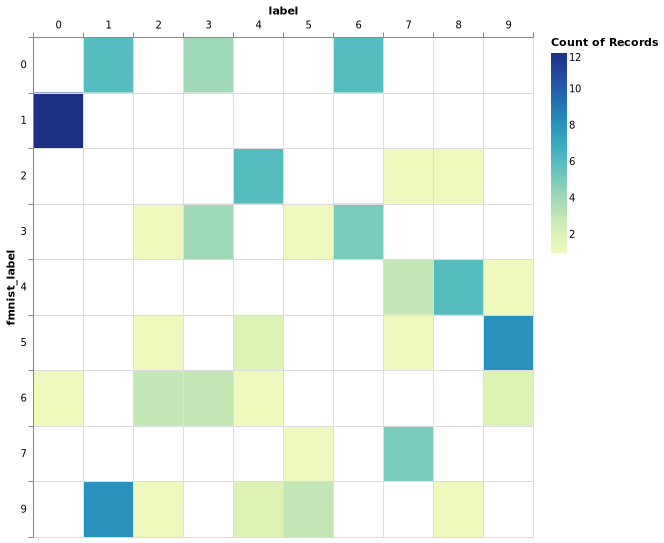

In [192]:
c1 = @vlplot(data=source,height=500,width=500,
    mark={:rect},
    x={field=:label,type="ordinal",sort="ascending",axis={orient="top",labelAngle=0}},
    y={field=:fmnist_label,type="ordinal",sort="ascending"},
    color={field=:label,aggregate="count"},
    config= {axis= {"grid"= true, "tickBand"= "extent"}}
)
# c2 = @vlplot(data=source,height=500,width=500,
#     mark={:circle,color="gray"},
#     x={field=:px,type="quantitative",sort="ascending",axis={orient="top",labelAngle=0}},
#     y={field=:py,type="quantitative",sort="descecnding"},
#     config= {axis= {"grid"= true, "tickBand"= "extent"}}
# )
# @vlplot() +c1 + c2